# Create a mesh from a dataset

## Import libraries and load dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd

## Read data

In [2]:
maritime_data = pd.read_csv("./Bat_and_Topo_arcachon/maritime_data.csv", sep=",", header=2)
earth_data = pd.read_csv("./Bat_and_Topo_arcachon/earth_data.csv", sep=",", header=3)

## Data processing
Transform csv data to numpy arrays to be plotted

Correct for real maximum water depth (opposite of dataset depth)

In [3]:
maritime_data.columns = ["long", "lat", "depth"]
maritime_data["depth"] = maritime_data["depth"]
maritime_depth = maritime_data["depth"]
maritime_long = maritime_data["long"].to_numpy()
maritime_lat = maritime_data["lat"].to_numpy()

earth_data=pd.DataFrame(np.array(earth_data),columns=['lat','long','depth','iteration'])
earth_depth = earth_data["depth"].to_numpy()
earth_long = earth_data["long"].to_numpy()
earth_lat = earth_data["lat"].to_numpy()

Changing scale

In [4]:
maritime_depth = maritime_depth*30
maritime_long = maritime_long*111000        
maritime_lat = maritime_lat*111000           

earth_depth=earth_depth*30
earth_lat=earth_lat*111000
earth_long=earth_long*111000

# Plot datasets
# Depth scale on the plots -> 1:1

Plot maritime data

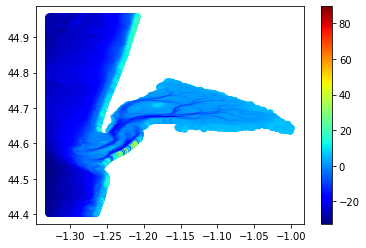

In [5]:
plt.figure()
plt.scatter(maritime_long/111000, maritime_lat/111000, c=maritime_depth/30, cmap="jet",linewidths=0.0000005)
plt.clim(vmin=np.min(maritime_depth/30),vmax=np.max(earth_depth/30))
plt.colorbar()
plt.savefig("Images/Mar_data.png")
plt.show()

Plot topography data

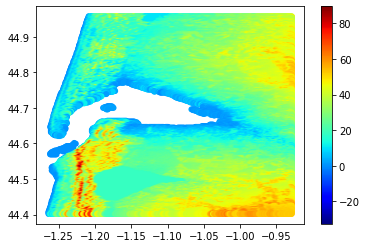

In [6]:
plt.figure()
plt.scatter(earth_long/111000, earth_lat/111000, c=earth_depth/30, cmap="jet",linewidths=0.0000005)
plt.clim(vmin=np.min(maritime_depth)/30,vmax=np.max(earth_depth)/30)
plt.colorbar()
plt.savefig("Images/Topo_data.png")
plt.show()


Plot topography and maritime data

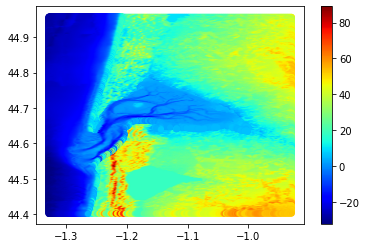

In [7]:
plt.figure()
plt.scatter(np.concatenate((earth_long/111000,maritime_long/111000)), np.concatenate((earth_lat/111000,maritime_lat/111000)), c=np.concatenate((earth_depth/30,maritime_depth/30)), cmap="jet",linewidths=0.0000005)
plt.clim(vmin=int(np.min(maritime_depth)/30),vmax=int(np.max(earth_depth)/30))
plt.colorbar()
plt.savefig("Images/Topo_Mar_data.png")
plt.show()

# Select dataset

options=0 # 0: earth+maritime, 1: earth, other cases: maritime


In [8]:
options=0 # 0: earth+maritime, 1: earth, other cases: maritime
if options==0:
    long=np.concatenate((maritime_long,earth_long))
    lat=np.concatenate((maritime_lat,earth_lat))
    depth=np.concatenate((maritime_depth,earth_depth))
elif options==1:
    long=earth_long
    lat=earth_lat
    depth=earth_depth
else :
    long=maritime_long
    lat=maritime_lat
    depth=maritime_depth


# Utilisation of k-nearest neighbors algorithme and its average depth to make the dataset more smooth

In [12]:
from sklearn.neighbors import NearestNeighbors

def smooth_grid(points,k_neigh=7):
    #points = points[points[:, 1].argsort()]
    #points = points[points[:, 0].argsort(kind='mergesort')]

    new_long=[]
    new_lat=[]
    new_depth=[]

    long=points[:,0]
    lat=points[:,1]
    matrix=np.array([long,lat]).T

    neigh = NearestNeighbors(n_neighbors=k_neigh)
    neigh.fit(matrix) 
    NearestNeighbors(algorithm='auto', leaf_size=30)

    for i in range(len(matrix)):
        if i%1000==999:
            print(f'{i+1} out of {len(matrix)}')
        neighbors=neigh.kneighbors([[matrix[i,0],matrix[i,1]]])[1][0]
        average_long=(np.sum([points[k,0] for k in neighbors])+points[i,0])/(k_neigh+1)
        average_lat=(np.sum([points[k,1] for k in neighbors])+points[i,1])/(k_neigh+1)
        average_depth=(np.sum([points[k,2] for k in neighbors])+points[i,2])/(k_neigh+1)
        new_long.append(average_long)
        new_lat.append(average_lat)
        new_depth.append(average_depth)
    
    return np.array([new_long,new_lat,new_depth]).T



In [13]:
points = np.array([long,lat,depth]).T
points=smooth_grid(points,50)

1000 out of 134691
2000 out of 134691
3000 out of 134691
4000 out of 134691
5000 out of 134691
6000 out of 134691
7000 out of 134691
8000 out of 134691
9000 out of 134691
10000 out of 134691
11000 out of 134691
12000 out of 134691
13000 out of 134691
14000 out of 134691
15000 out of 134691
16000 out of 134691
17000 out of 134691
18000 out of 134691
19000 out of 134691
20000 out of 134691
21000 out of 134691
22000 out of 134691
23000 out of 134691
24000 out of 134691
25000 out of 134691
26000 out of 134691
27000 out of 134691
28000 out of 134691
29000 out of 134691
30000 out of 134691
31000 out of 134691
32000 out of 134691
33000 out of 134691
34000 out of 134691
35000 out of 134691
36000 out of 134691
37000 out of 134691
38000 out of 134691
39000 out of 134691
40000 out of 134691
41000 out of 134691
42000 out of 134691
43000 out of 134691
44000 out of 134691
45000 out of 134691
46000 out of 134691
47000 out of 134691
48000 out of 134691
49000 out of 134691
50000 out of 134691
51000 out

## Mesh creation

In [14]:
import pyvista as pv
cloud = pv.PolyData(points)
grid = cloud.delaunay_2d(alpha=3000)   # We use the Delaunay method to make the mesh
print("Number of points",grid.number_of_points)
print("Number of cells",grid.number_of_cells)

Number of points 134691
Number of cells 267823


# Coloring cells and points
# Depth scale -> 1:1


In [15]:
import vtk
from vtk.util import numpy_support
#colors = vtk.vtkIntArray()
#colors.SetName("Depth (m)")
depth_scale=[]
for i in range(grid.number_of_cells):
    cell=grid.cell_points(i)
    sum=0
    for j in range(len(cell)):
        sum+=cell[j][2]/30
    sum=int(sum/len(cell))
    depth_scale.append(sum)

colors = numpy_support.numpy_to_vtk(depth_scale, deep=True, array_type=vtk.VTK_INT)
colors.SetName("Depth (m)")
grid.GetCellData().SetScalars(colors)
#for t in depth_scale:
    #colors.InsertNextValue(t)
#grid.GetCellData().SetScalars(colors)

0

In [16]:
#colors = vtk.vtkIntArray()
#colors.SetName("Depth (m)")
depth_scale=[]
for i in range(grid.number_of_points):
    depth_scale.append(int(points[i][2]/30))

colors = numpy_support.numpy_to_vtk(depth_scale, deep=True, array_type=vtk.VTK_INT)
colors.SetName("Depth (m)")
grid.GetPointData().SetScalars(colors)
#for t in depth_scale:
#    colors.InsertNextValue(t)
#grid.GetPointData().SetScalars(colors)

0

# Plot and save to vtk file

In [17]:
grid.plot(show_edges=True)
grid.save('./mesh_arcachon.vtk')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)